In [1]:
import pandas as pd
import numpy as np
import csv
from DeepSvDDClass import *
import torch

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
#don't use validation dataset since there is no overfitting in svdd?
def train_test(deepsvdd_datapath = None, split_ratio:float = 0.2):
    deepsvdd_data_csv = pd.read_csv(deepsvdd_datapath)
    
    #train data only needs normal data, test data need normal and abnormal data
    data_normal = deepsvdd_data_csv[(deepsvdd_data_csv["normal/abnormal"] == "normal" )]
    data_abnormal = deepsvdd_data_csv[(deepsvdd_data_csv["normal/abnormal"] == "abnormal" )]
    
    data_normal.loc[data_normal["normal/abnormal"] == "normal", "normal/abnormal"] = 1
    
    data_abnormal.loc[data_abnormal["normal/abnormal"] == "normal", "normal/abnormal"] = 1
    data_abnormal.loc[data_abnormal["normal/abnormal"] == "abnormal", "normal/abnormal"] = -1


    train_dataset_normal, test_dataset_normal  = train_test_split(data_normal, test_size=split_ratio, shuffle = False)
    
    train_dataset = train_dataset_normal
    test_dataset = pd.concat([test_dataset_normal, data_abnormal])
    
    return shuffle(train_dataset), shuffle(test_dataset)


datapath = r'C:\Users\brech\THESIS_local\ToyADMOS\DeepSVDD_case1_ch1.csv'
X_train, X_test = train_test(deepsvdd_datapath = datapath, split_ratio=0.2)

In [3]:
X_test

,normal/abnormal,rms,zcr,kurtosis,skewness,std,CF,SF,IF,CLF,centroid,entropy
1352,-1,0.151848,0.129653,0.745491,0.028946,0.151848,6.585543,1.291143,8.502877,10.192290,1870.212496,0.793677
1286,1,0.119374,0.129393,2.128690,-0.114000,0.119374,8.377061,1.351865,11.324654,13.918170,1730.823393,0.818323
1322,1,0.119796,0.131314,2.143400,-0.114286,0.119796,8.347510,1.363367,11.380720,14.094093,1803.665118,0.835701
1138,1,0.122434,0.118076,2.280188,-0.061763,0.122434,8.167643,1.370037,11.189970,13.887750,1618.806338,0.834833
1177,1,0.114520,0.126198,3.165989,-0.147821,0.114520,8.732118,1.428637,12.475024,16.001446,1668.635191,0.832913
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-1,0.114939,0.136246,3.252379,-0.144760,0.114939,8.700251,1.381910,12.022968,14.869246,1875.326084,0.796430
1307,1,0.122864,0.110660,1.613632,-0.055803,0.122864,8.139075,1.329363,10.819785,13.172830,1567.021985,0.823551
1269,1,0.143557,0.120705,1.662904,-0.072488,0.143557,6.965895,1.331250,9.273347,11.301557,1665.406955,0.835102
1171,1,0.118614,0.122499,2.730967,-0.103311,0.118614,8.430734,1.396464,11.773218,14.807151,1637.915785,0.798971


In [3]:
#target values y: 1 for positive(normal) and -1 for negative sample
Y_train_numpy = X_train["normal/abnormal"].to_numpy().reshape(-1, 1) #dimension is now (1080,1) instead of (1080,)
Y_test_numpy = X_test["normal/abnormal"].to_numpy().reshape(-1, 1) #dimension is now (1080,1) instead of (1080,)

#drop column of norm/abnorm, so train and test are only filled with the feature values
X_train = X_train.drop(columns=["normal/abnormal"])
X_test = X_test.drop(columns=["normal/abnormal"])

X_train_numpy = X_train.to_numpy() 
X_test_numpy = X_test.to_numpy()

print("X_train shape:" , X_train_numpy.shape,"\n",
      "X_test shape", X_test_numpy.shape,"\n",
      "Y_train shape:", Y_train_numpy.shape,"\n",
      "Y_test shape:", Y_test_numpy.shape)

X_train shape: (1080, 11) 
 X_test shape (534, 11) 
 Y_train shape: (1080, 1) 
 Y_test shape: (534, 1)


In [8]:
#using example 2 from https://github.com/iqiukp/SVDD-Python
X_train_numpy = X_train_numpy.astype(np.double) #cvxopt does not support ints, only doubles
X_test_numpy = X_test_numpy.astype(np.double) 
Y_train_numpy = Y_train_numpy.astype(np.double) 
Y_test_numpy = Y_test_numpy.astype(np.double) 

svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf')
svdd.fit(X_train_numpy,  Y_train_numpy)
y_test_predict = svdd.predict(X_test_numpy, Y_test_numpy)

#svdd = BaseSVDD(C = 0.1, degree =  2, kernel =  'poly') #52.06 percent accuracy
#svdd = BaseSVDD(C = 0.1, degree =  4, kernel =  'poly') #55.05 percent accuracy
#svdd = BaseSVDD(C = 0.5, degree =  5, kernel =  'poly') #58.05

#svdd = BaseSVDD(C = 0.1, gamma=0.3, kernel='linear')  #50.56 percent accuracy


#svdd = BaseSVDD(C = 0.1, gamma =  0.1, kernel =  'rbf')  #75.84 percent accuracy  
#svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf') #82 percent accuracy <<======= AUC curve lower than the one above?

#svdd = BaseSVDD(C = 0.1, gamma =  0.2, kernel =  'rbf')  #69.10 percent accuracy
#svdd = BaseSVDD(C = 0.1, gamma =  0.5, kernel =  'rbf')  #61.23 percent accuracy

#svdd = BaseSVDD(C = 0.5, gamma =  0.1, kernel =  'rbf')  #75.46 percent accuracy
#svdd = BaseSVDD(C = 1,   gamma =  0.1, kernel =  'rbf')  #75.28 percent accuracy





*** Fitting of the SVDD model is completed. ***

running time         = 1.5739 seconds
kernel function      = rbf
iterations           = 13
number of samples    = 1080
number of features   = 11
number of SVs        = 156
ratio of SVs         = 14.4444 %
accuracy             = 87.5926 %




*** Prediction of the provided data is completed. ***

running time         = 0.0400 seconds
number of samples    = 534
number of alarm      = 241
accuracy             = 82.5843 %




In [7]:
#figure out which comibination gives the best results
from sklearn.model_selection import learning_curve, GridSearchCV

param_grid = [
    {"kernel": ["rbf"], "gamma": [0.1, 0.2, 0.5], "C": [0.1, 0.5, 1]},
    {"kernel": ["linear"], "C": [0.1, 0.5, 1]},
    {"kernel": ["poly"], "C": [0.1, 0.5, 1], "degree": [2, 3, 4, 5]},
]

svdd = GridSearchCV(BaseSVDD(display='off'), param_grid, cv=5, scoring="accuracy")
svdd.fit(X_train_numpy, Y_train_numpy)
print("best parameters:")
print(svdd.best_params_)
print("\n")

# 
best_model = svdd.best_estimator_
means = svdd.cv_results_["mean_test_score"]
stds = svdd.cv_results_["std_test_score"]

for mean, std, params in zip(means, stds, svdd.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

c:\Users\brech\OneDrive\Documenten\THESIS\VScode\AI_pytorch_anomaly_detection\DeepSvDDClass.py:267: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
c:\Users\brech\OneDrive\Documenten\THESIS\VScode\AI_pytorch_anomaly_detection\DeepSvDDClass.py:267: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
c:\Users\brech\OneDrive\Documenten\THESIS\VScode\AI_pytorch_anomaly_detection\DeepSvDDClass.py:267: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
c:\Users\brech\OneDrive\Documenten\THESIS\VScode\AI_pytorch_anomaly_detection\DeepSvDDClass.py:267: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
c:\Users\brech\OneDrive\Documenten\THESIS\VScode\AI_pytorch_anomaly_detection\DeepSvDDClass.py:267: UserWarning: The fitted 

KeyboardInterrupt: 

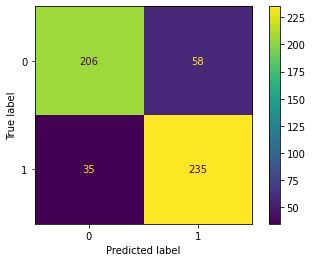

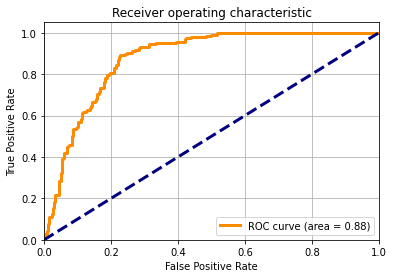

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# confusion matrix and ROC curve
cm = confusion_matrix(Y_test_numpy, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
y_score = svdd.decision_function(X_test_numpy)

fpr, tpr, _ = roc_curve(Y_test_numpy, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
"""In the basic approach of k-fold CV, the training set is split into k smaller sets.
The following procedure is followed for each of the k “folds”:
    1) A model is trained using k-1 of the folds as training data;
    2) The resulting model is validated on the remaining part of the data 
    (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. 
"""
#https://scikit-learn.org/stable/modules/cross_validation.html
#cross validation
from sklearn.model_selection import cross_val_score

svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf')

# cross validation (k-fold)
k = 5
scores = cross_val_score(svdd, X_train_numpy, Y_train_numpy, cv=k, scoring='accuracy')

#
print("Cross validation scores:")
for scores_ in scores:
    print(scores_)
 
print("Mean cross validation score: {:4f}".format(scores.mean()))